## Leading Terms of $\avg{GE_{a_1}  G^*E_{a_2}}$


In [2]:
# Imports and settings

from collections import defaultdict

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from graph_expansion import *
from graph_analysis import *


plt.rc(
    "text.latex",
    preamble=r"""
\usepackage{amsfonts}
\usepackage{amsmath}
\usepackage{mathtools}
\newcommand{\avg}[1]{\mathopen{}\left\langle #1 \right\rangle\mathclose{}}
\newcommand{\p}[1]{\mathopen{}\left\lparen #1 \right\rparen\mathclose{}}
\newcommand{\conj}[1]{\overline{#1}}
\newcommand{\G}{\widetilde{G}}
\newcommand{\m}{\mathbf{m}}
\newcommand{\E}{\mathbb{E}}
""",
)

In [3]:
# Helpers


def derivative_filter(x: Graph) -> bool:
    return sum([c.n_thetas for c in x.coefficients]) - len(x.deterministics) >= 4

In [4]:
# Main function to visualize deterministic graphs

node_size = 200
width = 2
arrowsize = 10
font_size = 10


def visualize_deterministic(
    x: Graph,
    external_vertices: list[Symbol],
    external_vertex_positions: Optional[dict[Symbol, list[float]]] = None,
    ax: Optional[Axes] = None,
    label_internal_vertices=False,
    with_external_edges=False,
    extra_edges: list[Coefficient] = [],
    auto_stheta_edges: list[tuple[Symbol, Symbol, Symbol, Symbol]] = [],
    ignored_edges: list[tuple[Symbol, Symbol]] = [],
    theta_edge_gap=1 / 16,
):
    g, node_charges, theta_edges, non_theta_edges = to_nx_graph(
        x,
        with_external_edges=with_external_edges,
        extra_edges=extra_edges,
        auto_stheta_edges=auto_stheta_edges,
        ignored_edges=ignored_edges,
    )

    pos = tutte_embedding(g, external_vertices, external_vertex_positions)
    # pos = nx.kamada_kawai_layout(g)
    # pos = nx.nx_pydot.graphviz_layout(g, prog="twopi")

    # Draw the graph
    if not ax:
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot()

    nx.draw_networkx_nodes(
        g,
        ax=ax,
        pos=pos,
        node_color=[get_charge_color(node_charges.get(u, Charge.Neutral)) if label_internal_vertices else (highlight_color if isinstance(u, a) else node_color) for u in g.nodes()],  # type: ignore
        node_size=node_size,
    )

    nx.draw_networkx_labels(
        g,
        ax=ax,
        pos=pos,
        labels={
            u: (
                f"${tex(u)}$"
                if label_internal_vertices
                else (
                    f"${tex(u)}$"
                    if not isinstance(u, b)
                    else get_charge_text(node_charges.get(u, Charge.Neutral))
                )
            )
            for u in g.nodes()
        },
        font_size=font_size,
    )

    nx.draw_networkx_edges(
        g,
        ax=ax,
        edgelist=non_theta_edges,
        pos=pos,
        edge_color=[get_edge_color(u, v, g[u][v]["matrix"]) for u, v in non_theta_edges],  # type: ignore
        style=[get_edge_style(g[u][v]["matrix"]) for u, v in non_theta_edges],  # type: ignore
        arrowstyle=[get_arrow_style(g[u][v]["matrix"]) for u, v in non_theta_edges],  # type: ignore
        width=width,
        arrowsize=arrowsize,
        node_size=node_size,
    )

    # draw_theta_edges(
    #     g,
    #     theta_edges,
    #     pos,
    #     ax,
    #     linestyle="--",
    #     dperp=theta_edge_gap,
    #     width=width,
    #     arrowsize=arrowsize,
    #     node_size=node_size,
    # )

    nx.draw_networkx_edges(
        g,
        ax=ax,
        edgelist=theta_edges,
        pos=pos,
        edge_color=[get_edge_color(u, v, g[u][v]["matrix"]) for u, v in theta_edges],  # type: ignore
        style=[get_edge_style(g[u][v]["matrix"]) for u, v in theta_edges],  # type: ignore
        arrowstyle=[get_arrow_style(g[u][v]["matrix"]) for u, v in theta_edges],  # type: ignore
        width=width,
        arrowsize=arrowsize,
        node_size=node_size,
    )

    # Manually draw legend
    # handles = []
    # labels = []

    # handles.append("neutral theta")
    # labels.append(R"$\Theta^{(\pm,\mp)}$")

    # handles.append("charged theta")
    # labels.append(R"$\Theta^{(\pm,\pm)}$")

    # handles.append("M")
    # labels.append(R"$M(\sigma)$")

    # handles.append("sigma")
    # labels.append(R"$\sigma$")
    # ax.legend(
    #     handles,
    #     labels,
    #     numpoints=1,
    #     handler_map={
    #         tuple: HandlerTuple(ndivide=None),
    #         "neutral theta": NeutralThetaHandler(),
    #         "charged theta": ChargedThetaHandler(),
    #         "M": MHandler(),
    #         "sigma": SigmaHandler(),
    #     },
    #     handlelength=3,
    # )

In [5]:
# Function to visualize molecular graphs


def make_molecular_graph(x: Graph):
    molecular_g = nx.MultiGraph()

    # Compute the molecules
    vertex_to_group: dict[Symbol, set[Symbol]] = {}
    for c in x.coefficients:
        if isinstance(c, STheta | Theta) and c.charges[0] == c.charges[1]:
            new_group = vertex_to_group.get(c.i, {c.i}) | vertex_to_group.get(
                c.j, {c.j}
            )
            for i in new_group:
                vertex_to_group[i] = new_group

    for t in x.traces:
        new_group = set.union(
            *[vertex_to_group.get(f.i, {f.i}) for f in t if isinstance(f, E)]
        )
        for i in new_group:
            vertex_to_group[i] = new_group

    # Helper maps for molecules
    molecule_to_vertices: dict[Symbol, set[Symbol]] = {}
    vertex_to_molecule: dict[Symbol, Symbol] = {}
    for group in vertex_to_group.values():
        if group not in molecule_to_vertices.values():
            next_m = m(len(molecule_to_vertices) + 1)
            molecule_to_vertices[next_m] = group
            for i in group:
                vertex_to_molecule[i] = next_m

    for a_i in [a(1), a(2)]:
        molecule_to_vertices[a_i] = {a_i}
        vertex_to_molecule[a_i] = a_i

    # Make the graph
    molecular_g.add_nodes_from(molecule_to_vertices.keys())
    external_edges: list[tuple[Symbol, Symbol, int]] = []
    internal_edges: list[tuple[Symbol, Symbol, int]] = []
    edge_counts: dict[tuple[Symbol, Symbol], int] = defaultdict(lambda: -1)
    for c in x.coefficients:
        if isinstance(c, STheta | Theta) and c.charges[0] != c.charges[1]:
            u, v = vertex_to_molecule[c.i], vertex_to_molecule[c.j]
            if (v, u) in edge_counts:
                u, v = v, u
            edge_counts[(u, v)] += 1
            molecular_g.add_edge(u, v)
            if isinstance(u, a) or isinstance(v, a):
                external_edges.append((u, v, edge_counts[(u, v)]))
            else:
                internal_edges.append((u, v, edge_counts[(u, v)]))
    return molecular_g, external_edges, internal_edges


def visualize_molecular(
    x: Graph,
    ax: Optional[Axes] = None,
):
    if not ax:
        fig = plt.figure()
        ax = fig.add_subplot()

    g, external_edges, internal_edges = make_molecular_graph(x)
    pos = nx.planar_layout(g)
    # Have to draw the edges separately because they won't arc correctly otherwise
    nx.draw_networkx_edges(
        g,
        pos,
        edgelist=external_edges,
        ax=ax,
    )
    nx.draw_networkx_edges(
        g,
        pos,
        edgelist=internal_edges,
        connectionstyle=[f"arc3,rad={k*0.2}" for _, _, k in internal_edges],
        ax=ax,
    )
    nx.draw_networkx_nodes(
        g,
        pos,
        node_color="none",
        edgecolors="black",
        ax=ax,
    )
    nx.draw_networkx_labels(g, pos, labels={u: f"${tex(u)}$" for u in g.nodes})

In [6]:
# Function to convert graphs to einsum calls


# Einsum for M = mI

alphabet = "abcdefghijklmnopqrstuvwxy"


def to_np_matrix(c: ChargedCoefficient) -> str:
    if isinstance(c, Theta):
        start = "Theta"
    else:
        assert isinstance(c, STheta)
        start = "t[:, None, None] * S_B @ Theta"
    c1, c2 = c.charges
    # c1_str = "p" if c1 == Charge.Plus else "m"
    # c2_str = "p" if c2 == Charge.Plus else "m"
    c_string = "pm" if c1 != c2 else ("pp" if c1 == Charge.Plus else "mm")
    return f"{start}_{c_string}"


def to_einsum_string(x: Graph):
    replacement_map: dict[Symbol, Symbol] = {}
    m_counts = [0, 0]  # [# M, # M^*]
    for t in x.traces:
        for f in t:
            if isinstance(f, M):
                if f.charge == Charge.Plus:
                    m_counts[0] += 1
                else:
                    m_counts[1] += 1

            if isinstance(f, E):
                replacement_map[f.i] = t[1].i

    new_coefficients: list[Coefficient] = []
    for c in x.coefficients:
        if isinstance(c, ChargedCoefficient):
            new_coefficients.append(
                type(c)(
                    c.charges[0],
                    c.charges[1],
                    replacement_map.get(c.i, c.i),
                    replacement_map.get(c.j, c.j),
                )
            )
        else:
            new_coefficients.append(
                type(c)(
                    replacement_map.get(c.i, c.i),
                    replacement_map.get(c.j, c.j),
                )
            )

    out = f"((m_E ** {m_counts[0]}) * (np.conj(m_E) ** {m_counts[1]}),"
    einsum_indices: list[list[str]] = []
    einsum_matrices: list[str] = []
    for c in new_coefficients:
        assert isinstance(c, ChargedCoefficient)
        assert isinstance(c.i, a | b)
        assert isinstance(c.j, a | b)

        einsum_indices.append(
            ["z"]
            + [
                alphabet[u.i - 1] if isinstance(u, a) else alphabet[u.i + 1]
                for u in [c.i, c.j]
            ]
        )
        einsum_matrices.append(to_np_matrix(c))

    out += '"' + ",".join(["".join(pair) for pair in einsum_indices]) + '->zab",'
    out += "[" + ", ".join(einsum_matrices) + "]),"
    return out

## Computations


In [7]:
# Compute relevant terms

x0 = Graph(
    Trace(
        G(),
        E(a(1)),
        adjoint(G()),
        E(a(2)),
    ),
)

LOL1 = compute_leading_terms(x0, 3, verbose=True, count_error_terms=True)
LOL1_groups = group_by_pattern(matrix_multiplication(LOL1))

<IPython.core.display.Latex object>

# order 3 deterministics:  136
# smaller graphs:          1000
# expansions:              227


In [8]:
# # Print out all drift terms


# total_n_derivatives = 0
# render(order(x0), R"\quad", x0)
# for x in sorted(drift_terms(x0), key=order):
#     render(x)
#     drift_leading_terms = matrix_multiplication(
#         compute_leading_terms(x, 3, verbose=False)
#     )
#     n_derivatives = len(list(filter(derivative_filter, drift_leading_terms)))
#     total_n_derivatives += n_derivatives
#     print(f"delta order needed: {3-order(x)}")
#     print(f"# derivative terms: {n_derivatives}")
#     print()
#     # render(order(x), R"\quad", x)
# print(f"# total derivative terms: {total_n_derivatives}")

## Analysis


In [9]:
# Guess on the simplified output


def small_filter(x: Graph) -> bool:
    return not any([isinstance(c, I) or isinstance(c, S) for c in x.coefficients])


def cheat(x: Graph) -> Graph:
    coefficients: list[Coefficient] = []
    for c in x.coefficients:
        if isinstance(c, ThetacalMS):
            coefficients.append(Theta(c.charges[0], c.charges[1], c.i, c.j))
        elif isinstance(c, SThetacalMS):
            coefficients.append(STheta(c.charges[0], c.charges[1], c.i, c.j))
        else:
            coefficients.append(c)
    return Graph(coefficients, x.traces)


cheated_leading_terms: list[Graph] = []
for pattern, graph_group in LOL1_groups.items():
    for x in filter(small_filter, graph_group):
        cheated_leading_terms.append(cheat(x))

cheated_patterns = group_by_pattern(cheated_leading_terms, signed=False)
len(cheated_leading_terms)

60

In [10]:
# Print out patterns


total_n_derivatives = 0
for i, (k, v) in enumerate(cheated_patterns.items()):
    n_graphs = len(v)
    n_thetas = sum([c.n_thetas for c in v[0].coefficients])
    n_derivatives = n_graphs * n_thetas
    total_n_derivatives += n_derivatives
    print(f"{n_graphs:>3}{n_thetas:>3} {', '.join(str(l) for l in k)}")
print(f"# total derivative terms: {total_n_derivatives}")

 10  7 (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0)
 25  6 (0, 0, 0), (0, 0, 0), (0, 0, 0, 0)
 14  5 (0, 0, 0), (0, 0, 0, 0, 0)
  6  5 (0, 0, 0, 0), (0, 0, 0, 0)
  5  4 (0, 0, 0, 0, 0, 0)
# total derivative terms: 340


In [11]:
# Print out number of black edges

n_long_edges_to_leading_term: dict[int, list[Graph]] = defaultdict(list)
for x in cheated_leading_terms:
    n_long_edges = len(
        [
            c
            for c in x.coefficients
            if isinstance(c, Theta | STheta) and c.charges[0] != c.charges[1]
        ]
    )
    n_long_edges_to_leading_term[n_long_edges].append(x)


for n, leading_terms in n_long_edges_to_leading_term.items():
    print(f"{n} {len(leading_terms):>2}")

5  9
4 18
3 17
2 16


In [12]:
# Count connected components


n_components: dict[int, int] = defaultdict(lambda: 0)
for x in cheated_leading_terms:
    g = nx.to_undirected(to_nx_graph(x, with_external_edges=False)[0])
    n_components[len(list(nx.connected_components(g)))] += 1
print(dict(n_components))

{1: 60}


# Visualization


In [13]:
PINF1 = Symbol(R"$+\infty_1$")
MINF1 = Symbol(R"$-\infty_1$")

PINF2 = Symbol(R"$+\infty_2$")
MINF2 = Symbol(R"$-\infty_2$")

external_vertices: list[Symbol] = [a(1), a(2)] + [PINF1, MINF1, PINF2, MINF2]

r, theta = 5, np.linspace(0, 2 * np.pi, endpoint=False, num=6) + np.pi / 2
pos = [[r * np.cos(t), r * np.sin(t)] for t in theta]

In [14]:
figsize = (8, 4)

## $5$ Long Edges ($9$ total)


In [15]:
# Print all terms out

for x in n_long_edges_to_leading_term[5]:
    render(x)

for x in n_long_edges_to_leading_term[5]:
    print(to_einsum_string(x))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

((m_E ** 4) * (np.conj(m_E) ** 8),"zal,zbe,zse,zis,zei,zls,zli->zab",[Theta_pm, Theta_pm, t[:, None, None] * S_B @ Theta_pm, t[:, None, None] * S_B @ Theta_pm, t[:, None, None] * S_B @ Theta_mm, t[:, None, None] * S_B @ Theta_mm, t[:, None, None] * S_B @ Theta_pm]),
((m_E ** 6) * (np.conj(m_E) ** 6),"zal,zbe,zle,zsi,zei,zls,zsi->zab",[Theta_pm, Theta_pm, t[:, None, None] * S_B @ Theta_pm, t[:, None, None] * S_B @ Theta_pm, t[:, None, None] * S_B @ Theta_mm, t[:, None, None] * S_B @ Theta_pp, t[:, None, None] * S_B @ Theta_pm]),
((m_E ** 6) * (np.conj(m_E) ** 6),"zak,zbe,zeh,zrh,zkr,zke,zrh->zab",[Theta_pm, Theta_pm, t[:, None, None] * S_B @ Theta_pp, t[:, None, None] * S_B @ Theta_pm, t[:, None, None] * S_B @ Theta_mm, t[:, None, None] * S_B @ Theta_pm, t[:, None, None] * S_B @ Theta_pm]),
((m_E ** 4) * (np.conj(m_E) ** 6),"zal,zbe,zle,zli,zei,zli->zab",[Theta_pm, Theta_pm, t[:, None, None] * S_B @ Theta_pm, t[:, None, None] * S_B @ Theta_pm, t[:, None, None] * S_B @ Theta_mm, t[:, Non

<IPython.core.display.Latex object>

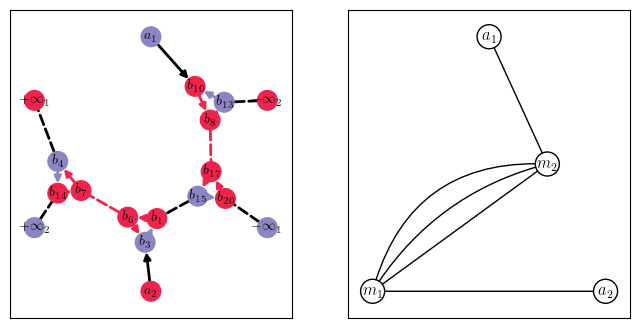

In [16]:
x = n_long_edges_to_leading_term[5][0]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[0],
        a(2): pos[3],
        PINF1: pos[1],
        MINF1: pos[4],
        PINF2: pos[2],
        MINF2: pos[5],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(4), b(20), PINF1, MINF1),
        (b(13), b(14), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

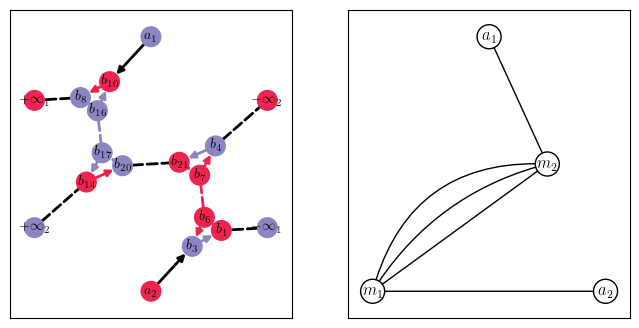

In [79]:
x = n_long_edges_to_leading_term[5][1]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[0],
        a(2): pos[3],
        PINF1: pos[1],
        MINF1: pos[4],
        PINF2: pos[2],
        MINF2: pos[5],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(8), b(1), PINF1, MINF1),
        (b(4), b(14), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

# plt.savefig("tutte.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

<IPython.core.display.Latex object>

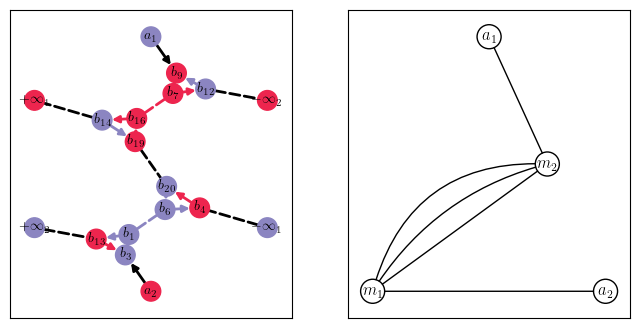

In [18]:
x = n_long_edges_to_leading_term[5][2]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[0],
        a(2): pos[3],
        PINF1: pos[1],
        MINF1: pos[4],
        PINF2: pos[2],
        MINF2: pos[5],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(14), b(4), PINF1, MINF1),
        (b(12), b(13), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

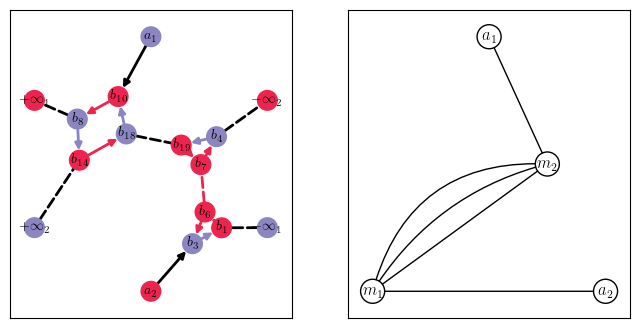

In [19]:
x = n_long_edges_to_leading_term[5][3]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[0],
        a(2): pos[3],
        PINF1: pos[1],
        MINF1: pos[4],
        PINF2: pos[2],
        MINF2: pos[5],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(8), b(1), PINF1, MINF1),
        (b(4), b(14), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

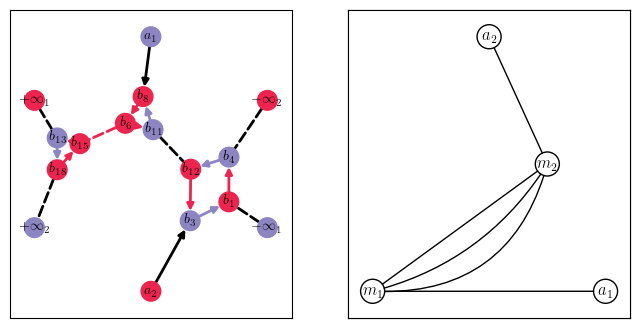

In [20]:
x = n_long_edges_to_leading_term[5][4]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)

visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[0],
        a(2): pos[3],
        PINF1: pos[1],
        MINF1: pos[4],
        PINF2: pos[2],
        MINF2: pos[5],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(13), b(1), PINF1, MINF1),
        (b(18), b(4), PINF2, MINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

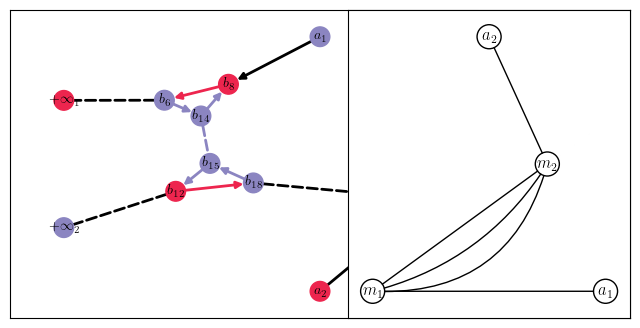

In [21]:
x = n_long_edges_to_leading_term[5][5]
render(x)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot()

visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[0],
        a(2): pos[3],
        PINF1: pos[1],
        MINF1: pos[4],
        PINF2: pos[2],
        MINF2: pos[5],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(6), b(1), PINF1, MINF1),
        (b(12), b(4), PINF2, MINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

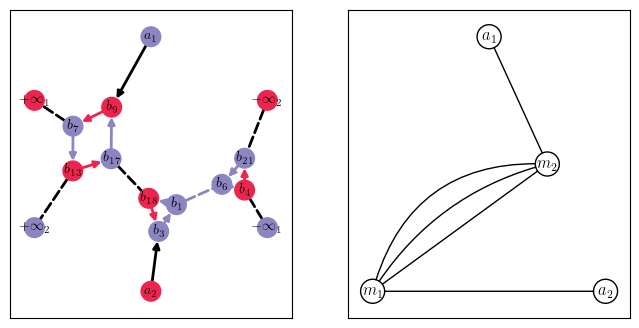

In [22]:
x = n_long_edges_to_leading_term[5][6]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)

visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[0],
        a(2): pos[3],
        PINF1: pos[1],
        MINF1: pos[4],
        PINF2: pos[2],
        MINF2: pos[5],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(7), b(4), PINF1, MINF1),
        (b(13), b(21), PINF2, MINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

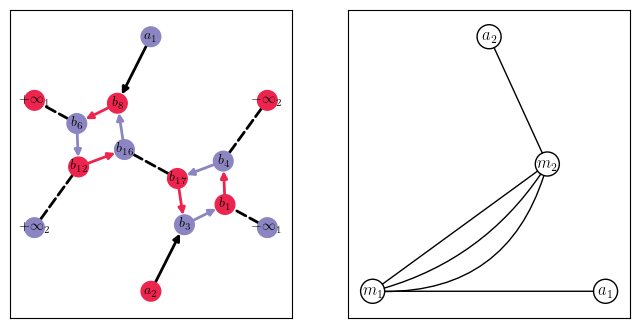

In [23]:
x = n_long_edges_to_leading_term[5][7]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)

visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[0],
        a(2): pos[3],
        PINF1: pos[1],
        MINF1: pos[4],
        PINF2: pos[2],
        MINF2: pos[5],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(6), b(1), PINF1, MINF1),
        (b(12), b(4), PINF2, MINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

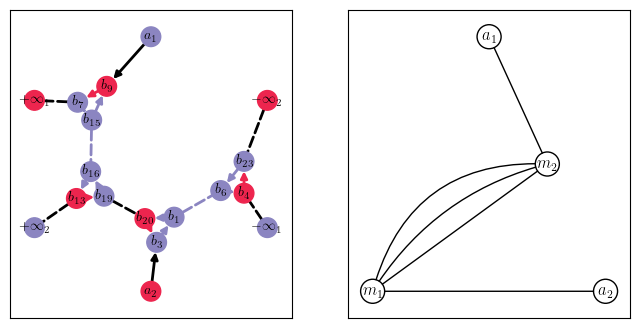

In [24]:
x = n_long_edges_to_leading_term[5][8]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)

visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[0],
        a(2): pos[3],
        PINF1: pos[1],
        MINF1: pos[4],
        PINF2: pos[2],
        MINF2: pos[5],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(7), b(4), PINF1, MINF1),
        (b(13), b(23), PINF2, MINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

## $4$ Long Edges ($18$ total)


In [25]:
# Print all terms out

for x in n_long_edges_to_leading_term[4]:
    render(x)

for x in n_long_edges_to_leading_term[4]:
    print(to_einsum_string(x))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

((m_E ** 3) * (np.conj(m_E) ** 7),"zai,zbe,zoe,zio,zei,zio->zab",[Theta_pm, Theta_pm, t[:, None, None] * S_B @ Theta_pm, t[:, None, None] * S_B @ Theta_pm, t[:, None, None] * S_B @ Theta_mm, t[:, None, None] * S_B @ Theta_mm]),
((m_E ** 3) * (np.conj(m_E) ** 7),"zal,zbe,zie,zil,zei,zli->zab",[Theta_pm, Theta_pm, t[:, None, None] * S_B @ Theta_pm, t[:, None, None] * S_B @ Theta_mm, t[:, None, None] * S_B @ Theta_mm, t[:, None, None] * S_B @ Theta_pm]),
((m_E ** 3) * (np.conj(m_E) ** 7),"zaj,zbe,zqe,zej,zjq,zeq->zab",[Theta_pm, Theta_pm, t[:, None, None] * S_B @ Theta_pm, t[:, None, None] * S_B @ Theta_mm, t[:, None, None] * S_B @ Theta_pm, t[:, None, None] * S_B @ Theta_mm]),
((m_E ** 5) * (np.conj(m_E) ** 5),"zal,zbe,zle,zii,zei,zli->zab",[Theta_pm, Theta_pm, t[:, None, None] * S_B @ Theta_pm, t[:, None, None] * S_B @ Theta_pm, t[:, None, None] * S_B @ Theta_mm, t[:, None, None] * S_B @ Theta_pp]),
((m_E ** 5) * (np.conj(m_E) ** 5),"zak,zbe,zeh,zhh,zkh,zke->zab",[Theta_pm, Theta_pm, t[

<IPython.core.display.Latex object>

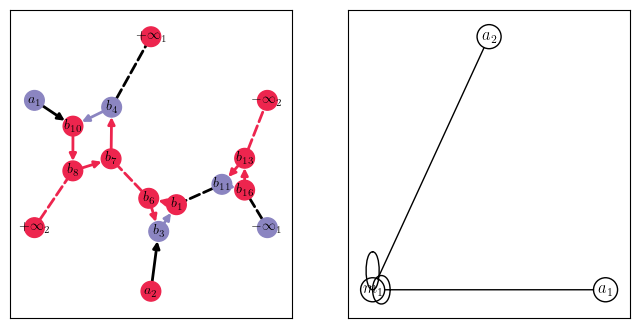

In [26]:
x = n_long_edges_to_leading_term[4][0]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[1],
        a(2): pos[3],
        PINF1: pos[0],
        MINF1: pos[4],
        PINF2: pos[2],
        MINF2: pos[5],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(4), b(16), PINF1, MINF1),
        (b(13), b(8), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

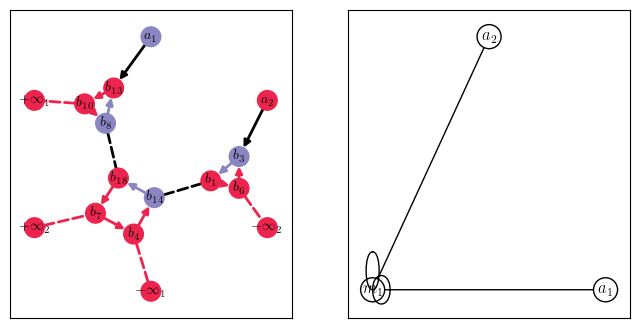

In [27]:
x = n_long_edges_to_leading_term[4][1]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[0],
        a(2): pos[5],
        PINF1: pos[1],
        MINF1: pos[3],
        PINF2: pos[2],
        MINF2: pos[4],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(10), b(4), PINF1, MINF1),
        (b(6), b(7), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

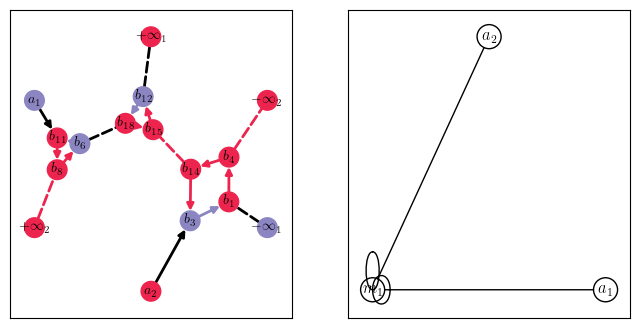

In [28]:
x = n_long_edges_to_leading_term[4][2]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[1],
        a(2): pos[3],
        PINF1: pos[0],
        MINF1: pos[4],
        PINF2: pos[2],
        MINF2: pos[5],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(12), b(1), PINF1, MINF1),
        (b(4), b(8), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

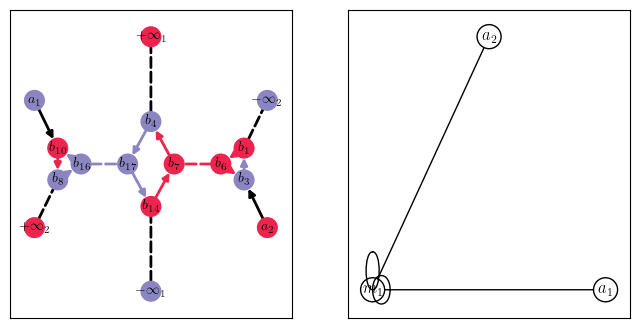

In [29]:
x = n_long_edges_to_leading_term[4][3]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[1],
        a(2): pos[4],
        PINF1: pos[0],
        MINF1: pos[3],
        PINF2: pos[2],
        MINF2: pos[5],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(4), b(14), PINF1, MINF1),
        (b(1), b(8), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

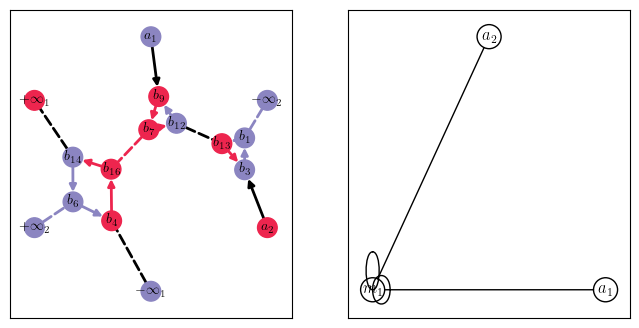

In [30]:
x = n_long_edges_to_leading_term[4][4]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[0],
        a(2): pos[4],
        PINF1: pos[1],
        MINF1: pos[3],
        PINF2: pos[2],
        MINF2: pos[5],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(14), b(4), PINF1, MINF1),
        (b(1), b(6), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

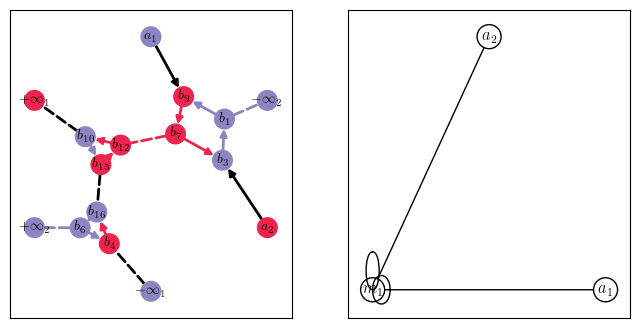

In [31]:
x = n_long_edges_to_leading_term[4][5]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[0],
        a(2): pos[4],
        PINF1: pos[1],
        MINF1: pos[3],
        PINF2: pos[2],
        MINF2: pos[5],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(10), b(4), PINF1, MINF1),
        (b(1), b(6), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

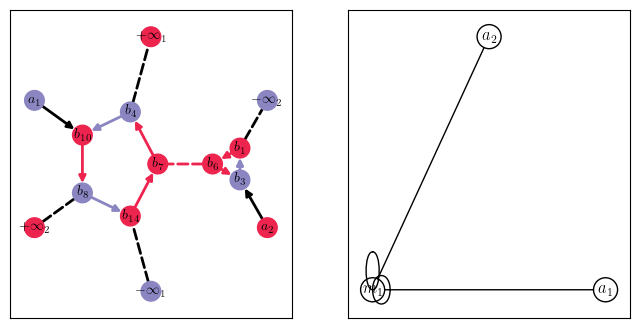

In [32]:
x = n_long_edges_to_leading_term[4][6]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[1],
        a(2): pos[4],
        PINF1: pos[0],
        MINF1: pos[3],
        PINF2: pos[2],
        MINF2: pos[5],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(4), b(14), PINF1, MINF1),
        (b(1), b(8), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

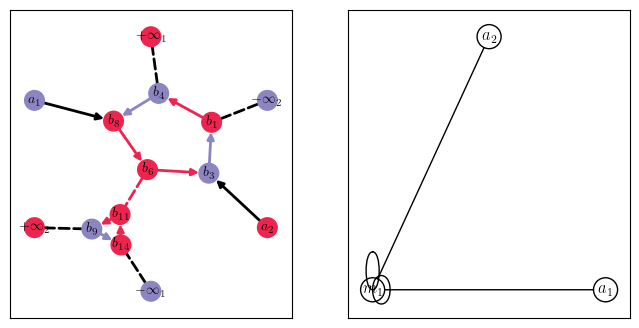

In [33]:
x = n_long_edges_to_leading_term[4][7]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[1],
        a(2): pos[4],
        PINF1: pos[0],
        MINF1: pos[3],
        PINF2: pos[2],
        MINF2: pos[5],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(4), b(14), PINF1, MINF1),
        (b(1), b(9), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

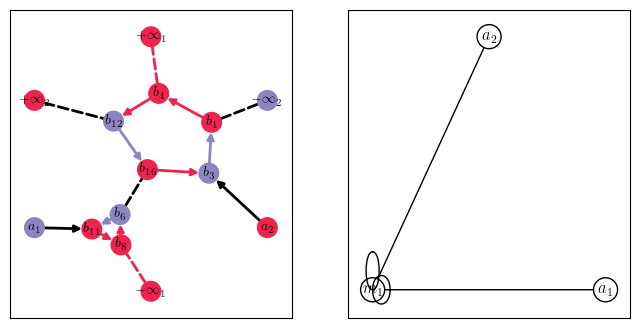

In [34]:
x = n_long_edges_to_leading_term[4][8]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[2],
        a(2): pos[4],
        PINF1: pos[0],
        MINF1: pos[3],
        PINF2: pos[1],
        MINF2: pos[5],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(4), b(8), PINF1, MINF1),
        (b(1), b(12), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

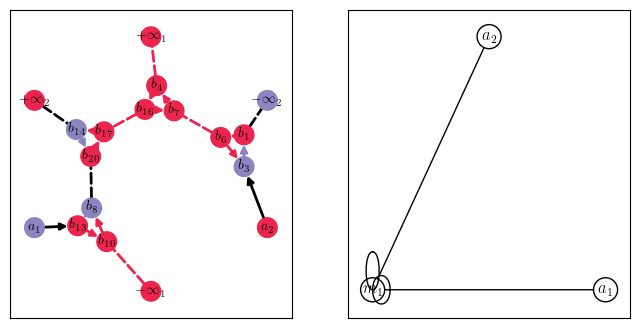

In [35]:
x = n_long_edges_to_leading_term[4][9]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[2],
        a(2): pos[4],
        PINF1: pos[0],
        MINF1: pos[3],
        PINF2: pos[1],
        MINF2: pos[5],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(4), b(10), PINF1, MINF1),
        (b(1), b(14), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

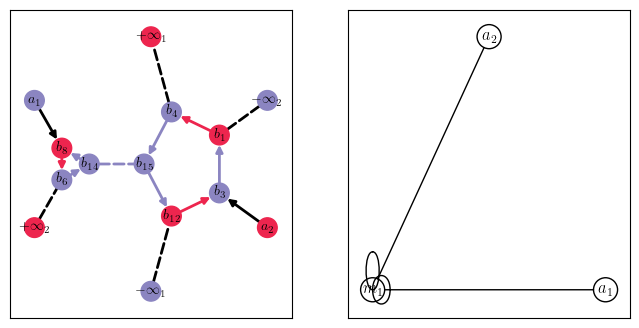

In [36]:
x = n_long_edges_to_leading_term[4][10]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[1],
        a(2): pos[4],
        PINF1: pos[0],
        MINF1: pos[3],
        PINF2: pos[2],
        MINF2: pos[5],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(4), b(12), PINF1, MINF1),
        (b(1), b(6), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

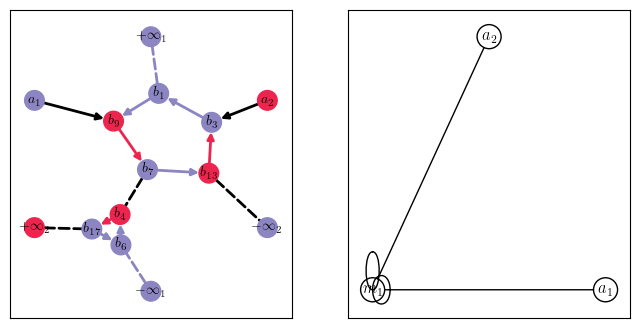

In [37]:
x = n_long_edges_to_leading_term[4][11]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[1],
        a(2): pos[5],
        PINF1: pos[0],
        MINF1: pos[3],
        PINF2: pos[2],
        MINF2: pos[4],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(1), b(6), PINF1, MINF1),
        (b(13), b(17), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

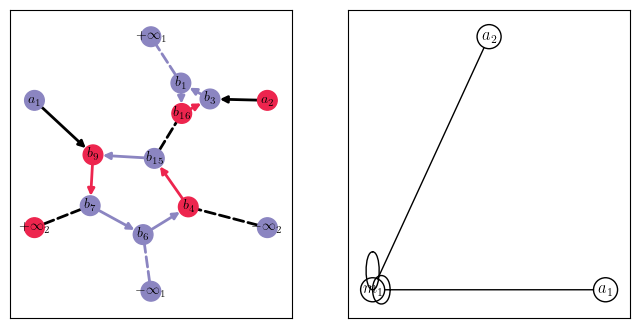

In [38]:
x = n_long_edges_to_leading_term[4][12]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[1],
        a(2): pos[5],
        PINF1: pos[0],
        MINF1: pos[3],
        PINF2: pos[2],
        MINF2: pos[4],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(1), b(6), PINF1, MINF1),
        (b(7), b(4), PINF2, MINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

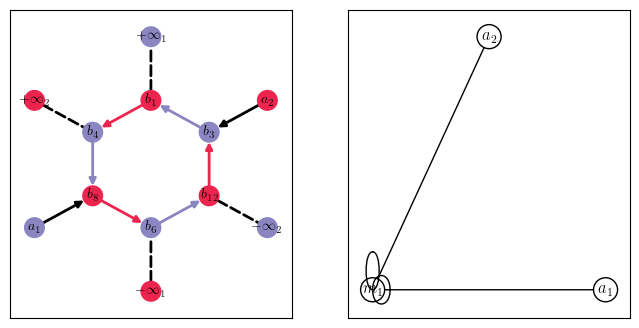

In [39]:
x = n_long_edges_to_leading_term[4][13]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[2],
        a(2): pos[5],
        PINF1: pos[0],
        MINF1: pos[3],
        PINF2: pos[1],
        MINF2: pos[4],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(1), b(6), PINF1, MINF1),
        (b(12), b(4), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

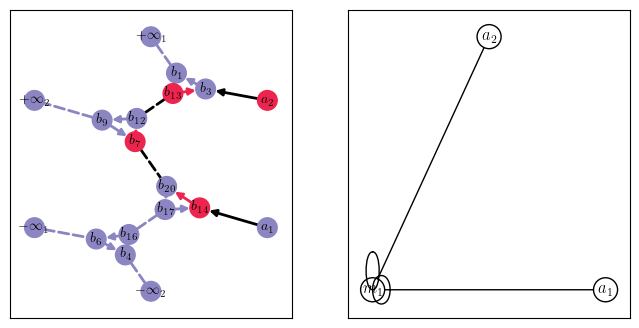

In [40]:
x = n_long_edges_to_leading_term[4][14]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[4],
        a(2): pos[5],
        PINF1: pos[0],
        MINF1: pos[2],
        PINF2: pos[1],
        MINF2: pos[3],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(1), b(6), PINF1, MINF1),
        (b(9), b(4), PINF2, MINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

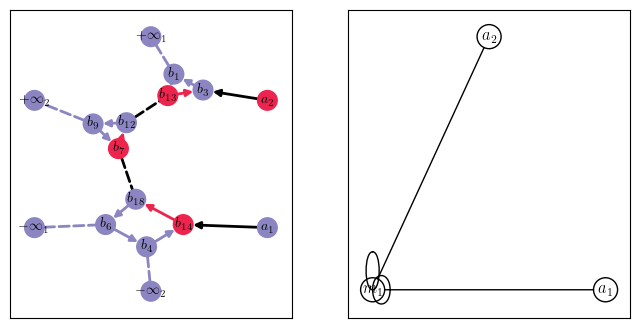

In [41]:
x = n_long_edges_to_leading_term[4][15]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[4],
        a(2): pos[5],
        PINF1: pos[0],
        MINF1: pos[2],
        PINF2: pos[1],
        MINF2: pos[3],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(1), b(6), PINF1, MINF1),
        (b(9), b(4), PINF2, MINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

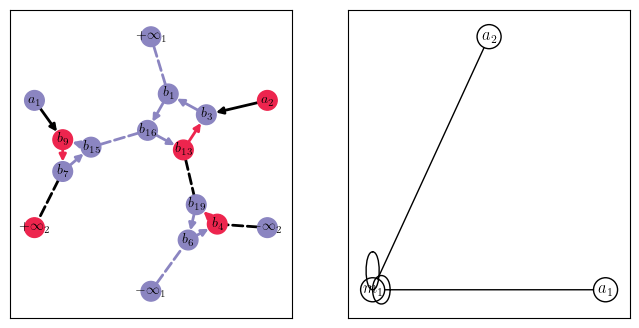

In [42]:
x = n_long_edges_to_leading_term[4][16]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[1],
        a(2): pos[5],
        PINF1: pos[0],
        MINF1: pos[3],
        PINF2: pos[2],
        MINF2: pos[4],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(1), b(6), PINF1, MINF1),
        (b(7), b(4), PINF2, MINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

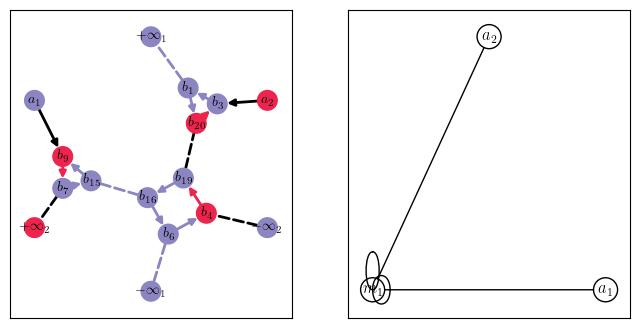

In [43]:
x = n_long_edges_to_leading_term[4][17]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[1],
        a(2): pos[5],
        PINF1: pos[0],
        MINF1: pos[3],
        PINF2: pos[2],
        MINF2: pos[4],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(1), b(6), PINF1, MINF1),
        (b(7), b(4), PINF2, MINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

## $3$ Long Edges ($17$ total)


In [44]:
# Print all terms out

for x in n_long_edges_to_leading_term[3]:
    render(x)

for x in n_long_edges_to_leading_term[3]:
    print(to_einsum_string(x))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

((m_E ** 2) * (np.conj(m_E) ** 10),"zas,zbe,zse,zil,zei,zli,zls->zab",[Theta_pm, Theta_pm, t[:, None, None] * S_B @ Theta_pm, t[:, None, None] * S_B @ Theta_mm, t[:, None, None] * S_B @ Theta_mm, t[:, None, None] * S_B @ Theta_mm, t[:, None, None] * S_B @ Theta_mm]),
((m_E ** 2) * (np.conj(m_E) ** 8),"zal,zbe,zle,zil,zei,zli->zab",[Theta_pm, Theta_pm, t[:, None, None] * S_B @ Theta_pm, t[:, None, None] * S_B @ Theta_mm, t[:, None, None] * S_B @ Theta_mm, t[:, None, None] * S_B @ Theta_mm]),
((m_E ** 2) * (np.conj(m_E) ** 8),"zaq,zbe,zqe,zej,zje,zjq->zab",[Theta_pm, Theta_pm, t[:, None, None] * S_B @ Theta_pm, t[:, None, None] * S_B @ Theta_mm, t[:, None, None] * S_B @ Theta_mm, t[:, None, None] * S_B @ Theta_mm]),
((m_E ** 2) * (np.conj(m_E) ** 8),"zap,zbe,zpe,zll,zel,zlp->zab",[Theta_pm, Theta_pm, t[:, None, None] * S_B @ Theta_pm, t[:, None, None] * S_B @ Theta_mm, t[:, None, None] * S_B @ Theta_mm, t[:, None, None] * S_B @ Theta_mm]),
((m_E ** 2) * (np.conj(m_E) ** 6),"zal,zbe,zle,z

<IPython.core.display.Latex object>

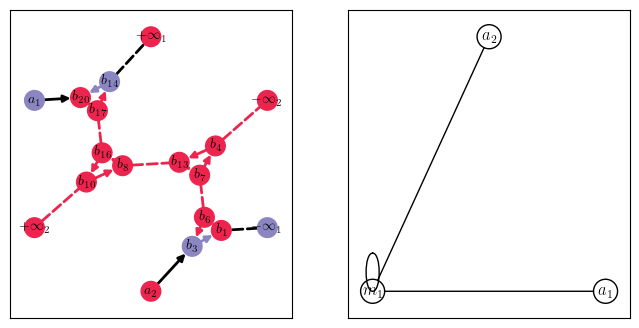

In [45]:
x = n_long_edges_to_leading_term[3][0]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[1],
        a(2): pos[3],
        PINF1: pos[0],
        MINF1: pos[4],
        PINF2: pos[2],
        MINF2: pos[5],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(14), b(1), PINF1, MINF1),
        (b(4), b(10), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

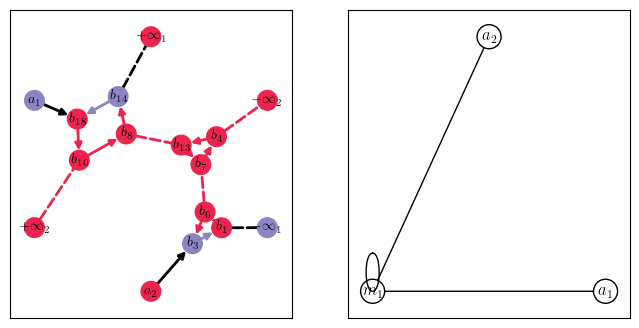

In [46]:
x = n_long_edges_to_leading_term[3][1]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[1],
        a(2): pos[3],
        PINF1: pos[0],
        MINF1: pos[4],
        PINF2: pos[2],
        MINF2: pos[5],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(14), b(1), PINF1, MINF1),
        (b(4), b(10), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

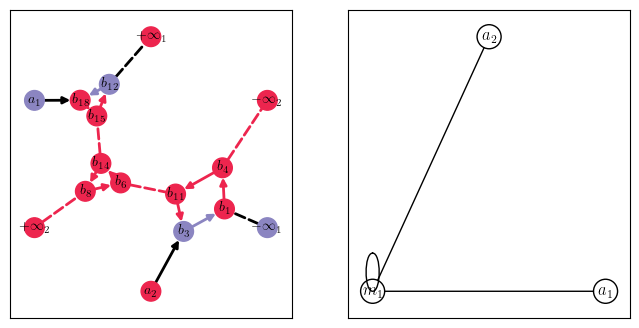

In [47]:
x = n_long_edges_to_leading_term[3][2]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[1],
        a(2): pos[3],
        PINF1: pos[0],
        MINF1: pos[4],
        PINF2: pos[2],
        MINF2: pos[5],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(12), b(1), PINF1, MINF1),
        (b(4), b(8), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

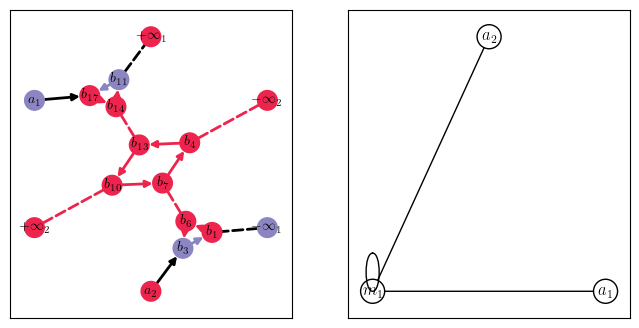

In [48]:
x = n_long_edges_to_leading_term[3][3]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[1],
        a(2): pos[3],
        PINF1: pos[0],
        MINF1: pos[4],
        PINF2: pos[2],
        MINF2: pos[5],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(11), b(1), PINF1, MINF1),
        (b(4), b(10), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

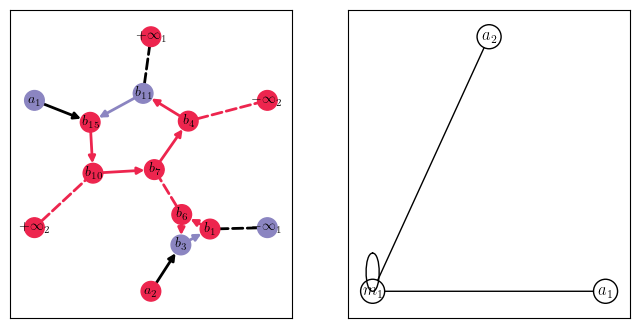

In [49]:
x = n_long_edges_to_leading_term[3][4]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[1],
        a(2): pos[3],
        PINF1: pos[0],
        MINF1: pos[4],
        PINF2: pos[2],
        MINF2: pos[5],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(11), b(1), PINF1, MINF1),
        (b(4), b(10), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

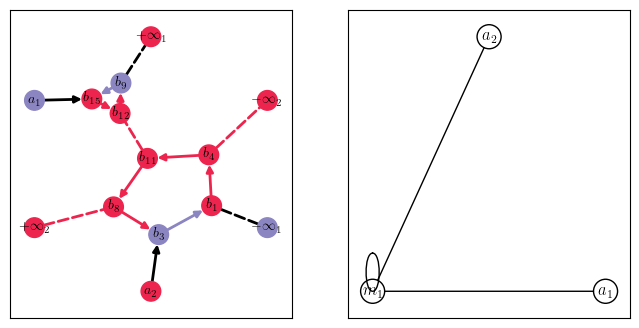

In [50]:
x = n_long_edges_to_leading_term[3][5]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[1],
        a(2): pos[3],
        PINF1: pos[0],
        MINF1: pos[4],
        PINF2: pos[2],
        MINF2: pos[5],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(9), b(1), PINF1, MINF1),
        (b(4), b(8), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

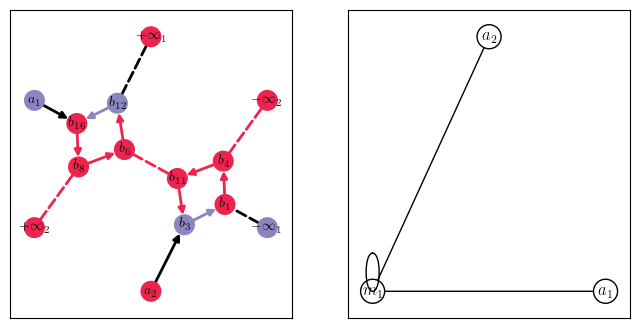

In [51]:
x = n_long_edges_to_leading_term[3][6]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[1],
        a(2): pos[3],
        PINF1: pos[0],
        MINF1: pos[4],
        PINF2: pos[2],
        MINF2: pos[5],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(12), b(1), PINF1, MINF1),
        (b(4), b(8), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

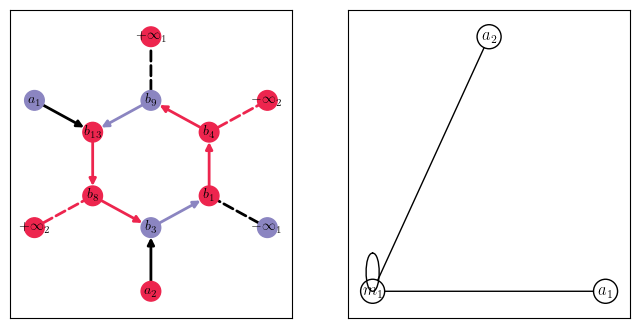

In [52]:
x = n_long_edges_to_leading_term[3][7]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[1],
        a(2): pos[3],
        PINF1: pos[0],
        MINF1: pos[4],
        PINF2: pos[2],
        MINF2: pos[5],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(9), b(1), PINF1, MINF1),
        (b(4), b(8), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

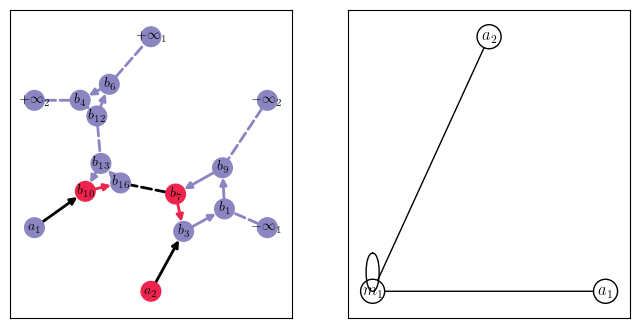

In [53]:
x = n_long_edges_to_leading_term[3][8]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[2],
        a(2): pos[3],
        PINF1: pos[0],
        MINF1: pos[4],
        PINF2: pos[1],
        MINF2: pos[5],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(6), b(1), PINF1, MINF1),
        (b(4), b(9), PINF2, MINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

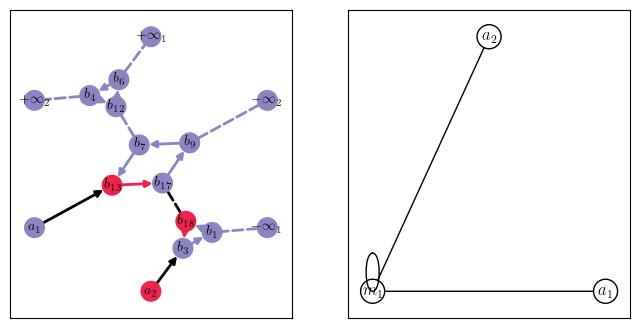

In [54]:
x = n_long_edges_to_leading_term[3][9]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[2],
        a(2): pos[3],
        PINF1: pos[0],
        MINF1: pos[4],
        PINF2: pos[1],
        MINF2: pos[5],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(6), b(1), PINF1, MINF1),
        (b(4), b(9), PINF2, MINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

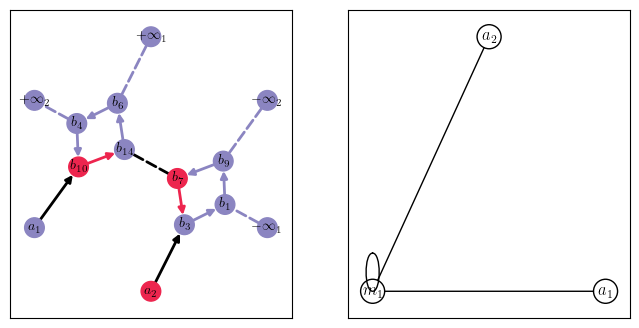

In [55]:
x = n_long_edges_to_leading_term[3][10]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[2],
        a(2): pos[3],
        PINF1: pos[0],
        MINF1: pos[4],
        PINF2: pos[1],
        MINF2: pos[5],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(6), b(1), PINF1, MINF1),
        (b(4), b(9), PINF2, MINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

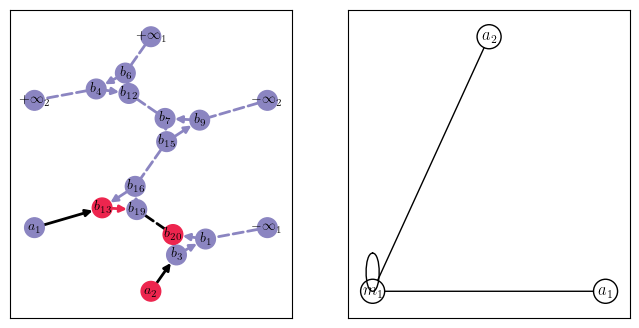

In [56]:
x = n_long_edges_to_leading_term[3][11]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[2],
        a(2): pos[3],
        PINF1: pos[0],
        MINF1: pos[4],
        PINF2: pos[1],
        MINF2: pos[5],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(6), b(1), PINF1, MINF1),
        (b(4), b(9), PINF2, MINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

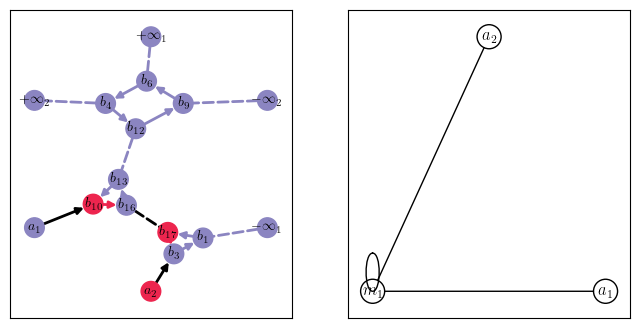

In [57]:
x = n_long_edges_to_leading_term[3][12]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[2],
        a(2): pos[3],
        PINF1: pos[0],
        MINF1: pos[4],
        PINF2: pos[1],
        MINF2: pos[5],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(6), b(1), PINF1, MINF1),
        (b(4), b(9), PINF2, MINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

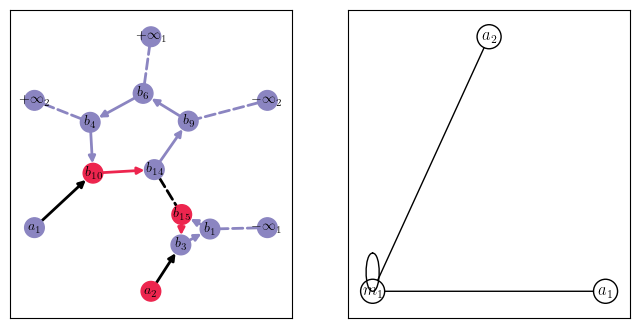

In [58]:
x = n_long_edges_to_leading_term[3][13]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[2],
        a(2): pos[3],
        PINF1: pos[0],
        MINF1: pos[4],
        PINF2: pos[1],
        MINF2: pos[5],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(6), b(1), PINF1, MINF1),
        (b(4), b(9), PINF2, MINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

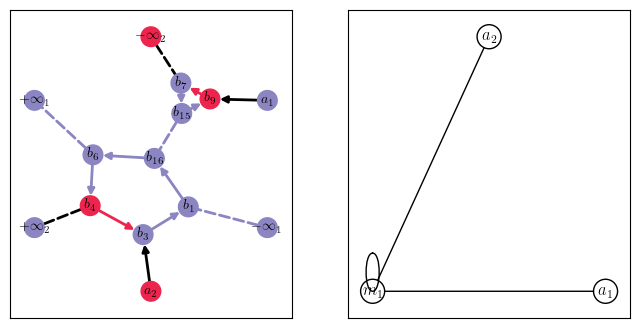

In [59]:
x = n_long_edges_to_leading_term[3][14]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[5],
        a(2): pos[3],
        PINF1: pos[1],
        MINF1: pos[4],
        PINF2: pos[2],
        MINF2: pos[0],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(6), b(1), PINF1, MINF1),
        (b(4), b(7), PINF2, MINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

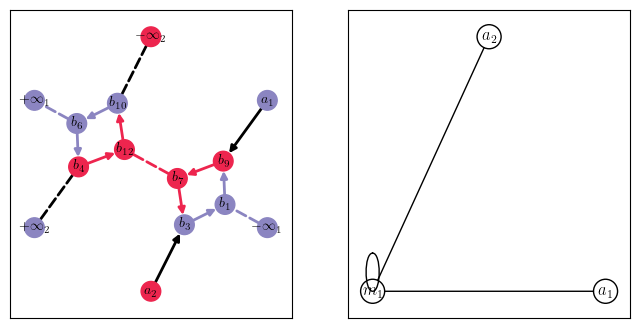

In [60]:
x = n_long_edges_to_leading_term[3][15]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[5],
        a(2): pos[3],
        PINF1: pos[1],
        MINF1: pos[4],
        PINF2: pos[2],
        MINF2: pos[0],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(6), b(1), PINF1, MINF1),
        (b(4), b(10), PINF2, MINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

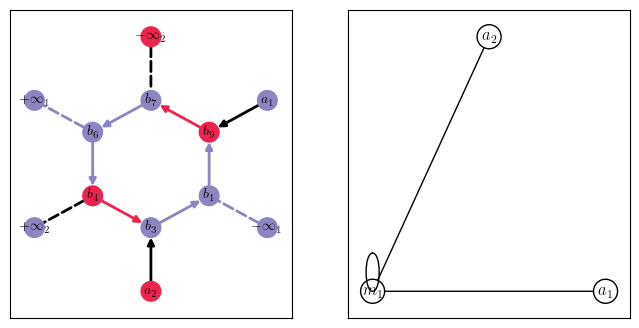

In [61]:
x = n_long_edges_to_leading_term[3][16]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[5],
        a(2): pos[3],
        PINF1: pos[1],
        MINF1: pos[4],
        PINF2: pos[2],
        MINF2: pos[0],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(6), b(1), PINF1, MINF1),
        (b(4), b(7), PINF2, MINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

## $2$ Long Edges ($16$ total)


In [62]:
# Print all terms out

for x in n_long_edges_to_leading_term[2]:
    render(x)

for x in n_long_edges_to_leading_term[2]:
    print(to_einsum_string(x))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

((m_E ** 1) * (np.conj(m_E) ** 11),"zae,zbe,zis,zei,zms,zim,zsm->zab",[Theta_pm, Theta_pm, t[:, None, None] * S_B @ Theta_mm, t[:, None, None] * S_B @ Theta_mm, t[:, None, None] * S_B @ Theta_mm, t[:, None, None] * S_B @ Theta_mm, t[:, None, None] * S_B @ Theta_mm]),
((m_E ** 1) * (np.conj(m_E) ** 9),"zae,zbe,zis,zei,zss,zis->zab",[Theta_pm, Theta_pm, t[:, None, None] * S_B @ Theta_mm, t[:, None, None] * S_B @ Theta_mm, t[:, None, None] * S_B @ Theta_mm, t[:, None, None] * S_B @ Theta_mm]),
((m_E ** 1) * (np.conj(m_E) ** 9),"zae,zbe,ziq,zei,ziq,zqi->zab",[Theta_pm, Theta_pm, t[:, None, None] * S_B @ Theta_mm, t[:, None, None] * S_B @ Theta_mm, t[:, None, None] * S_B @ Theta_mm, t[:, None, None] * S_B @ Theta_mm]),
((m_E ** 1) * (np.conj(m_E) ** 7),"zae,zbe,zqq,zeq,zqq->zab",[Theta_pm, Theta_pm, t[:, None, None] * S_B @ Theta_mm, t[:, None, None] * S_B @ Theta_mm, t[:, None, None] * S_B @ Theta_mm]),
((m_E ** 1) * (np.conj(m_E) ** 9),"zae,zbe,zeq,zkq,zek,zqk->zab",[Theta_pm, Theta_pm, t

<IPython.core.display.Latex object>

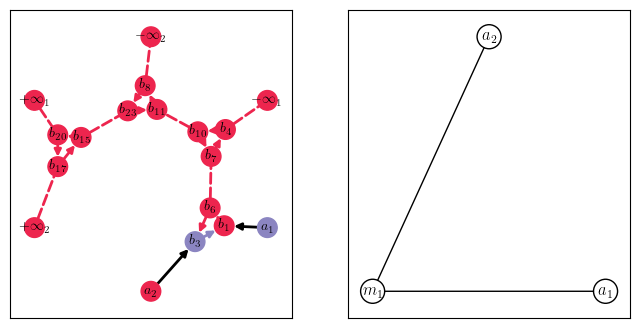

In [63]:
x = n_long_edges_to_leading_term[2][0]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[4],
        a(2): pos[3],
        PINF1: pos[1],
        MINF1: pos[5],
        PINF2: pos[2],
        MINF2: pos[0],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(4), b(20), MINF1, PINF1),
        (b(8), b(17), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

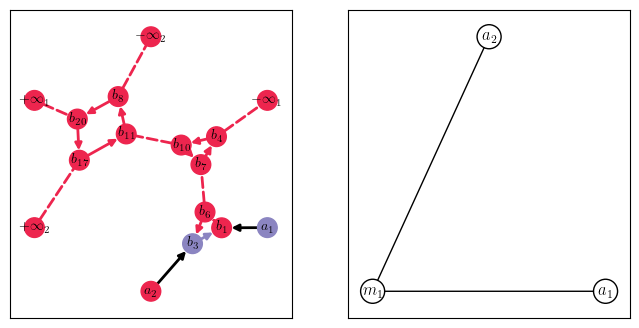

In [64]:
x = n_long_edges_to_leading_term[2][1]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[4],
        a(2): pos[3],
        PINF1: pos[1],
        MINF1: pos[5],
        PINF2: pos[2],
        MINF2: pos[0],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(4), b(20), MINF1, PINF1),
        (b(8), b(17), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

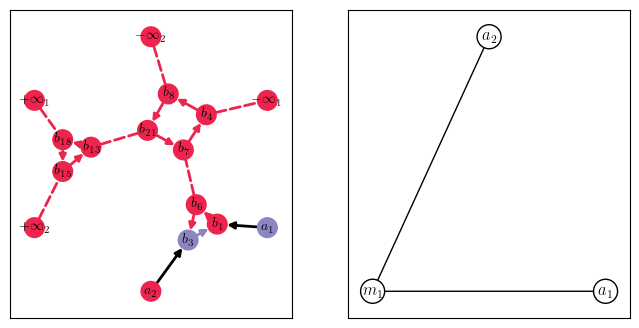

In [65]:
x = n_long_edges_to_leading_term[2][2]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[4],
        a(2): pos[3],
        PINF1: pos[1],
        MINF1: pos[5],
        PINF2: pos[2],
        MINF2: pos[0],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(4), b(18), MINF1, PINF1),
        (b(8), b(15), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

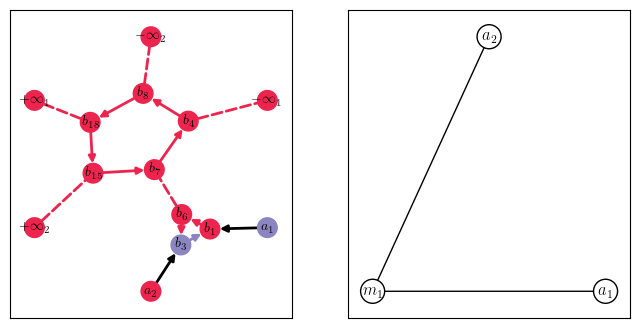

In [66]:
x = n_long_edges_to_leading_term[2][3]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[4],
        a(2): pos[3],
        PINF1: pos[1],
        MINF1: pos[5],
        PINF2: pos[2],
        MINF2: pos[0],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(4), b(18), MINF1, PINF1),
        (b(8), b(15), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

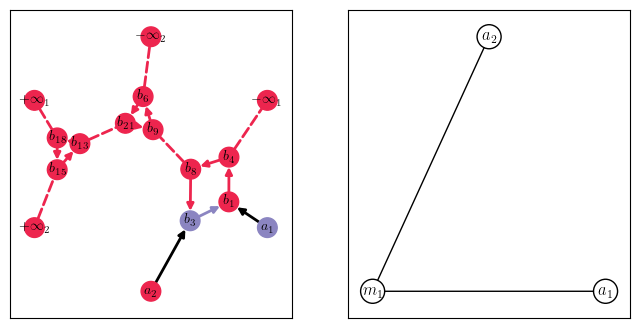

In [67]:
x = n_long_edges_to_leading_term[2][4]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[4],
        a(2): pos[3],
        PINF1: pos[1],
        MINF1: pos[5],
        PINF2: pos[2],
        MINF2: pos[0],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(4), b(18), MINF1, PINF1),
        (b(6), b(15), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

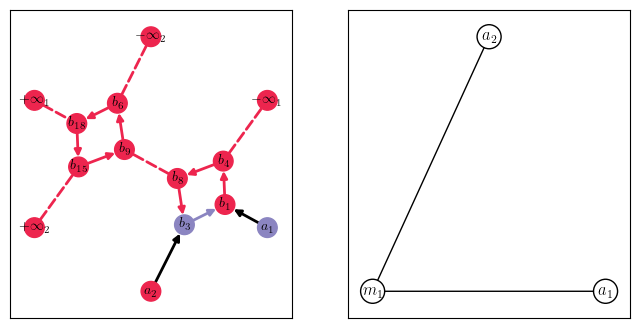

In [68]:
x = n_long_edges_to_leading_term[2][5]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[4],
        a(2): pos[3],
        PINF1: pos[1],
        MINF1: pos[5],
        PINF2: pos[2],
        MINF2: pos[0],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(4), b(18), MINF1, PINF1),
        (b(6), b(15), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

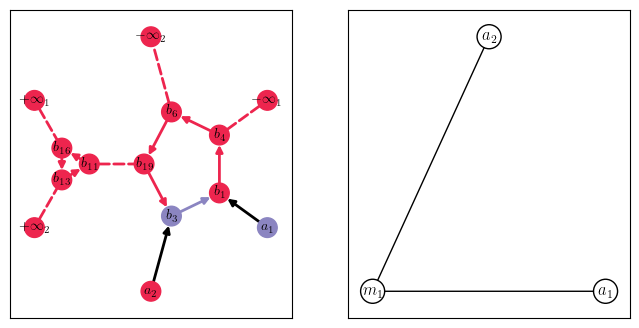

In [69]:
x = n_long_edges_to_leading_term[2][6]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[4],
        a(2): pos[3],
        PINF1: pos[1],
        MINF1: pos[5],
        PINF2: pos[2],
        MINF2: pos[0],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(4), b(16), MINF1, PINF1),
        (b(6), b(13), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

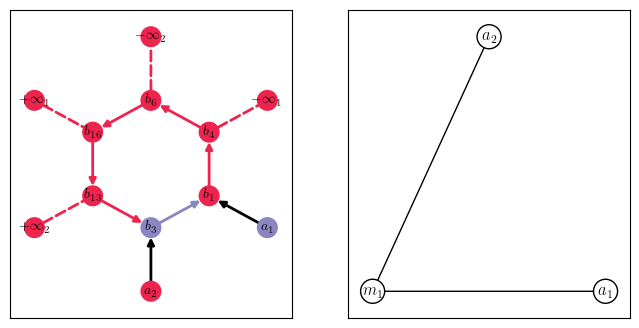

In [70]:
x = n_long_edges_to_leading_term[2][7]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[4],
        a(2): pos[3],
        PINF1: pos[1],
        MINF1: pos[5],
        PINF2: pos[2],
        MINF2: pos[0],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(4), b(16), MINF1, PINF1),
        (b(6), b(13), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

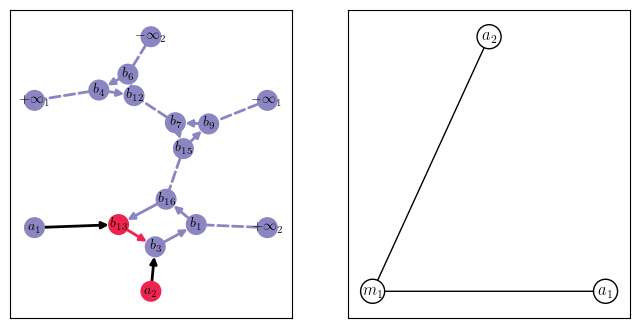

In [71]:
x = n_long_edges_to_leading_term[2][8]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[2],
        a(2): pos[3],
        PINF1: pos[1],
        MINF1: pos[5],
        PINF2: pos[4],
        MINF2: pos[0],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(4), b(9), PINF1, MINF1),
        (b(6), b(1), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

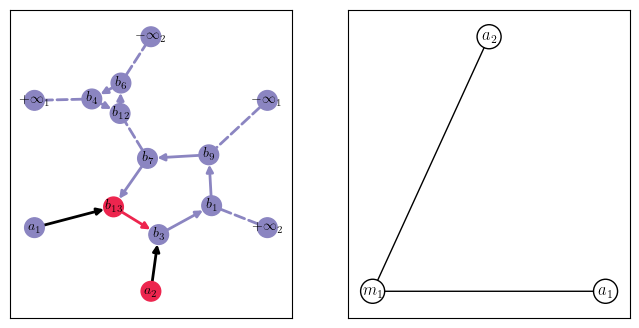

In [72]:
x = n_long_edges_to_leading_term[2][9]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[2],
        a(2): pos[3],
        PINF1: pos[1],
        MINF1: pos[5],
        PINF2: pos[4],
        MINF2: pos[0],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(4), b(9), PINF1, MINF1),
        (b(6), b(1), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

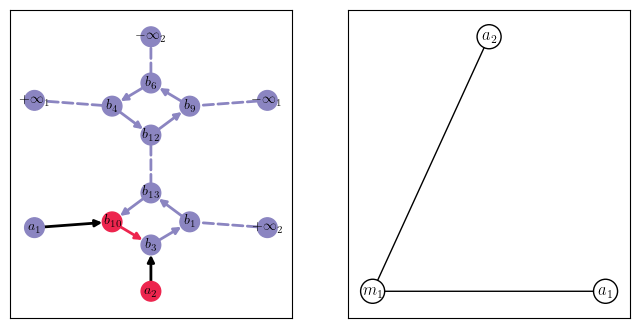

In [73]:
x = n_long_edges_to_leading_term[2][10]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[2],
        a(2): pos[3],
        PINF1: pos[1],
        MINF1: pos[5],
        PINF2: pos[4],
        MINF2: pos[0],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(4), b(9), PINF1, MINF1),
        (b(6), b(1), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

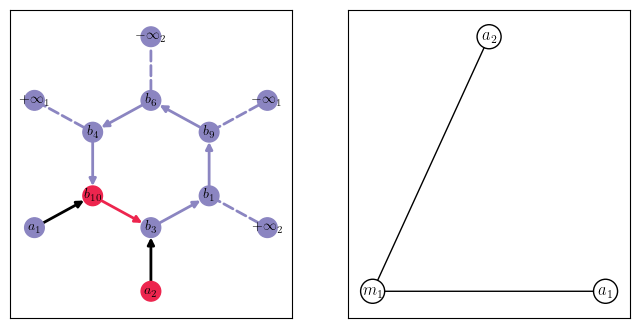

In [74]:
x = n_long_edges_to_leading_term[2][11]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[2],
        a(2): pos[3],
        PINF1: pos[1],
        MINF1: pos[5],
        PINF2: pos[4],
        MINF2: pos[0],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(4), b(9), PINF1, MINF1),
        (b(6), b(1), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

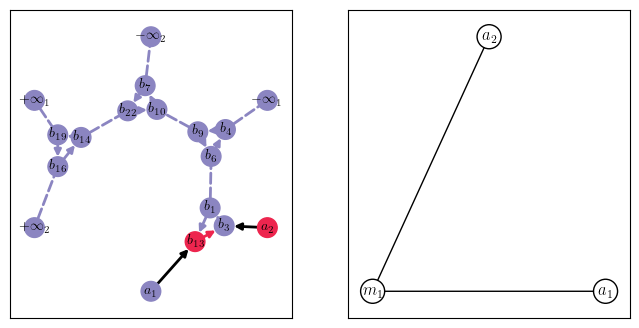

In [75]:
x = n_long_edges_to_leading_term[2][12]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[3],
        a(2): pos[4],
        PINF1: pos[1],
        MINF1: pos[5],
        PINF2: pos[2],
        MINF2: pos[0],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(4), b(19), MINF1, PINF1),
        (b(7), b(16), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

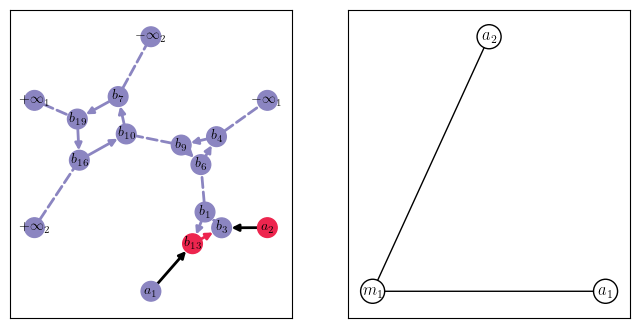

In [76]:
x = n_long_edges_to_leading_term[2][13]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[3],
        a(2): pos[4],
        PINF1: pos[1],
        MINF1: pos[5],
        PINF2: pos[2],
        MINF2: pos[0],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(4), b(19), MINF1, PINF1),
        (b(7), b(16), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

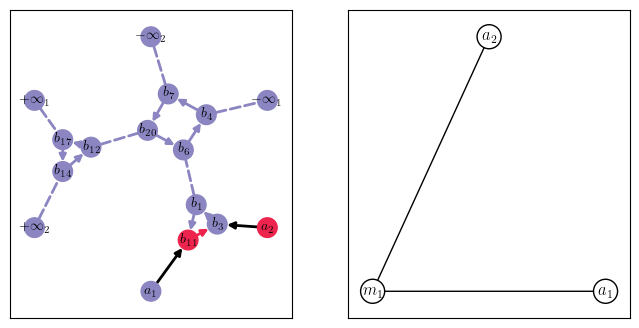

In [77]:
x = n_long_edges_to_leading_term[2][14]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[3],
        a(2): pos[4],
        PINF1: pos[1],
        MINF1: pos[5],
        PINF2: pos[2],
        MINF2: pos[0],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(4), b(17), MINF1, PINF1),
        (b(7), b(14), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()

<IPython.core.display.Latex object>

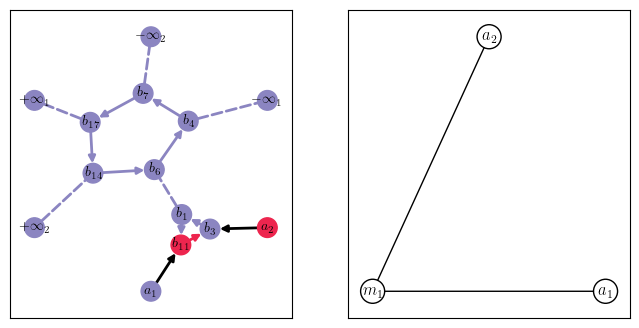

In [78]:
x = n_long_edges_to_leading_term[2][15]
render(x)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(121)
visualize_deterministic(
    x,
    external_vertices=external_vertices,
    external_vertex_positions={
        a(1): pos[3],
        a(2): pos[4],
        PINF1: pos[1],
        MINF1: pos[5],
        PINF2: pos[2],
        MINF2: pos[0],
    },
    ax=ax,
    label_internal_vertices=True,
    auto_stheta_edges=[
        (b(4), b(17), MINF1, PINF1),
        (b(7), b(14), MINF2, PINF2),
    ],
)

ax = fig.add_subplot(122)
visualize_molecular(x, ax)

plt.show()